In [74]:
import csv
import os

#import biosppy.signals.ecg as ecg
from biosppy.signals import ecg

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [75]:
y_train_df = pd.read_csv('data/y_train.csv', index_col='id')
#X_train_df = pd.read_csv('data/X_train.csv', index_col='id')
#X_test_df = pd.read_csv('data/X_test.csv', index_col='id')
X_train_f_df = pd.read_csv('data/X_train_filtered.csv')
X_test_f_df = pd.read_csv('data/X_test_filtered.csv')

## process the inputs
Fs = 300    # Hz

In [138]:
period_max = np.zeros(X_train_df.shape[0])
period_min = np.zeros(X_train_df.shape[0])
period_mean = np.zeros(X_train_df.shape[0])
period_var = np.zeros(X_train_df.shape[0])
## find the r-peaks using biosppy
for rr in range(X_train_df.shape[0]):
    signal = X_train_df.loc[rr].dropna().to_numpy(dtype='float32')
    r_peaks = ecg.engzee_segmenter(signal, Fs)['rpeaks']
    if len(r_peaks) < 2:
        r_peaks = ecg.engzee_segmenter(-signal, Fs)['rpeaks']
    
    periods = np.diff(r_peaks)
    period_max[rr] = np.amax(periods)
    period_min[rr] = np.amin(periods)
    period_mean[rr] = np.mean(periods)
    period_var[rr] = np.var(periods)
    
    
d = {'max': period_max, 'min': period_min, 'mean': period_mean, 'variance': period_var}
df = pd.DataFrame(data=d)

In [157]:
period_max = np.zeros(X_test_df.shape[0])
period_min = np.zeros(X_test_df.shape[0])
period_mean = np.zeros(X_test_df.shape[0])
period_var = np.zeros(X_test_df.shape[0])
## find the r-peaks using biosppy
for rr in range(X_test_df.shape[0]):
    signal = X_test_df.loc[rr].dropna().to_numpy(dtype='float32')
    r_peaks = ecg.engzee_segmenter(signal, Fs)['rpeaks']
    if len(r_peaks) < 2:
        r_peaks = ecg.engzee_segmenter(-signal, Fs)['rpeaks']
    
    periods = np.diff(r_peaks)
    period_max[rr] = np.amax(periods)
    period_min[rr] = np.amin(periods)
    period_mean[rr] = np.mean(periods)
    period_var[rr] = np.var(periods)
    
    
d = {'max': period_max, 'min': period_min, 'mean': period_mean, 'variance': period_var}
test_df = pd.DataFrame(data=d)

In [76]:
# Retrieve one sample recording per class for plotting

labels_train = y_train_df['y'].to_numpy()
labels0_train = 1*(labels_train == 3)
# for i in range(len(labels_train)):
#     if labels_train[i] == 3:
#         labels0_train[i] = 0
#     else:
            
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_train == class_id)[0]))
    
# Print indices of the sample signals
sample_signal_ids

[0, 3, 4, 30]

In [77]:
mlpc = MLPClassifier(random_state=10, max_iter=10000, activation='tanh',solver='sgd', hidden_layer_sizes=(500,500))
mlpc.fit(x, y_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

### Pay attention to NaN values! 

Unlike many medical application, these NaNs **DO NOT** represent missing values but appear because of variable length of the signals. ECG recordings normally don't have missing values and are sampled equally.

Despite being put into a tabular CSV format / Pandas Dataframe, the data is still a raw signal with variable lengths. Coumns *x0, ..., x17841* correspond to measurements at time stamps *0, ..., 17841* and not to different features of the data point. If the signal is too short then all the coumns after the last measurement have NaN values,

## Plot sample signals for each class

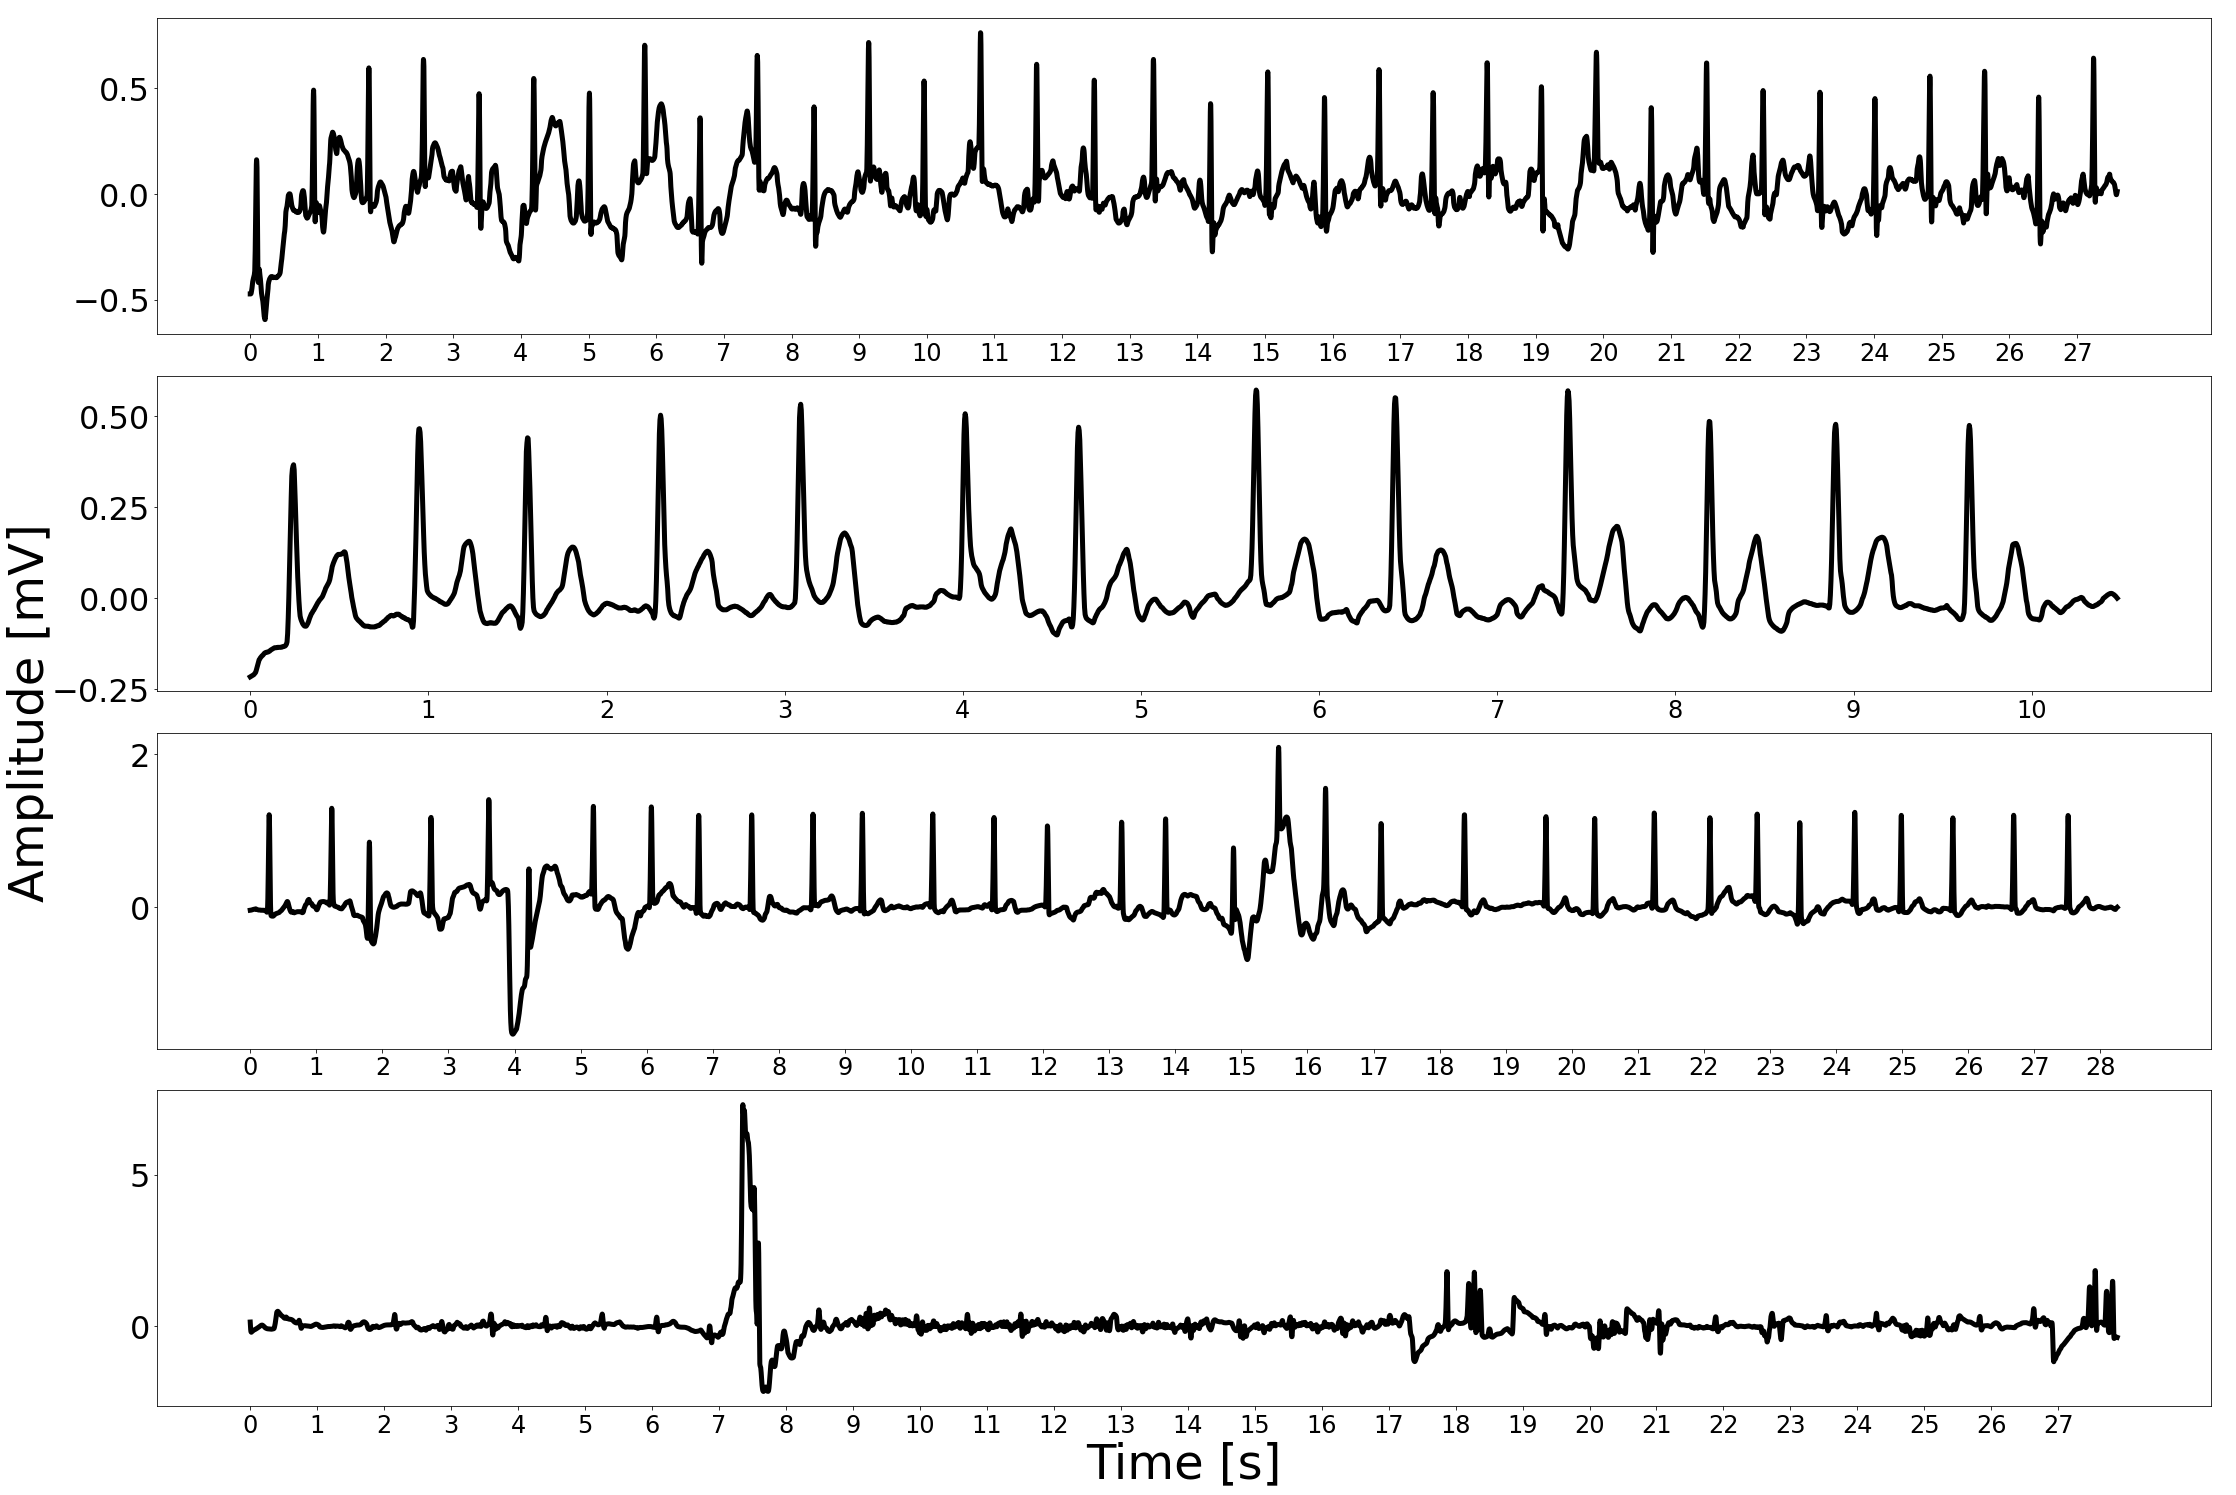

In [78]:
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_train == class_id)[20]))

T = 50      # sec
Offset = 0 # sec

# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(4, 1)



for class_id in range(num_classes):
    ax = axs[class_id]
    #ax.set_title("Class {}".format(class_id))
    
    measurements0 = X_train_df.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    if len(measurements0) < Fs*(Offset + T):
        start = Fs*Offset
        end = len(measurements0)
    else:
        start = Fs*Offset
        end = Fs*(Offset + T)
    
    seconds = np.arange(start, end) / Fs 
    x_labels = np.arange(start/Fs, end/Fs)
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements0[start: end] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

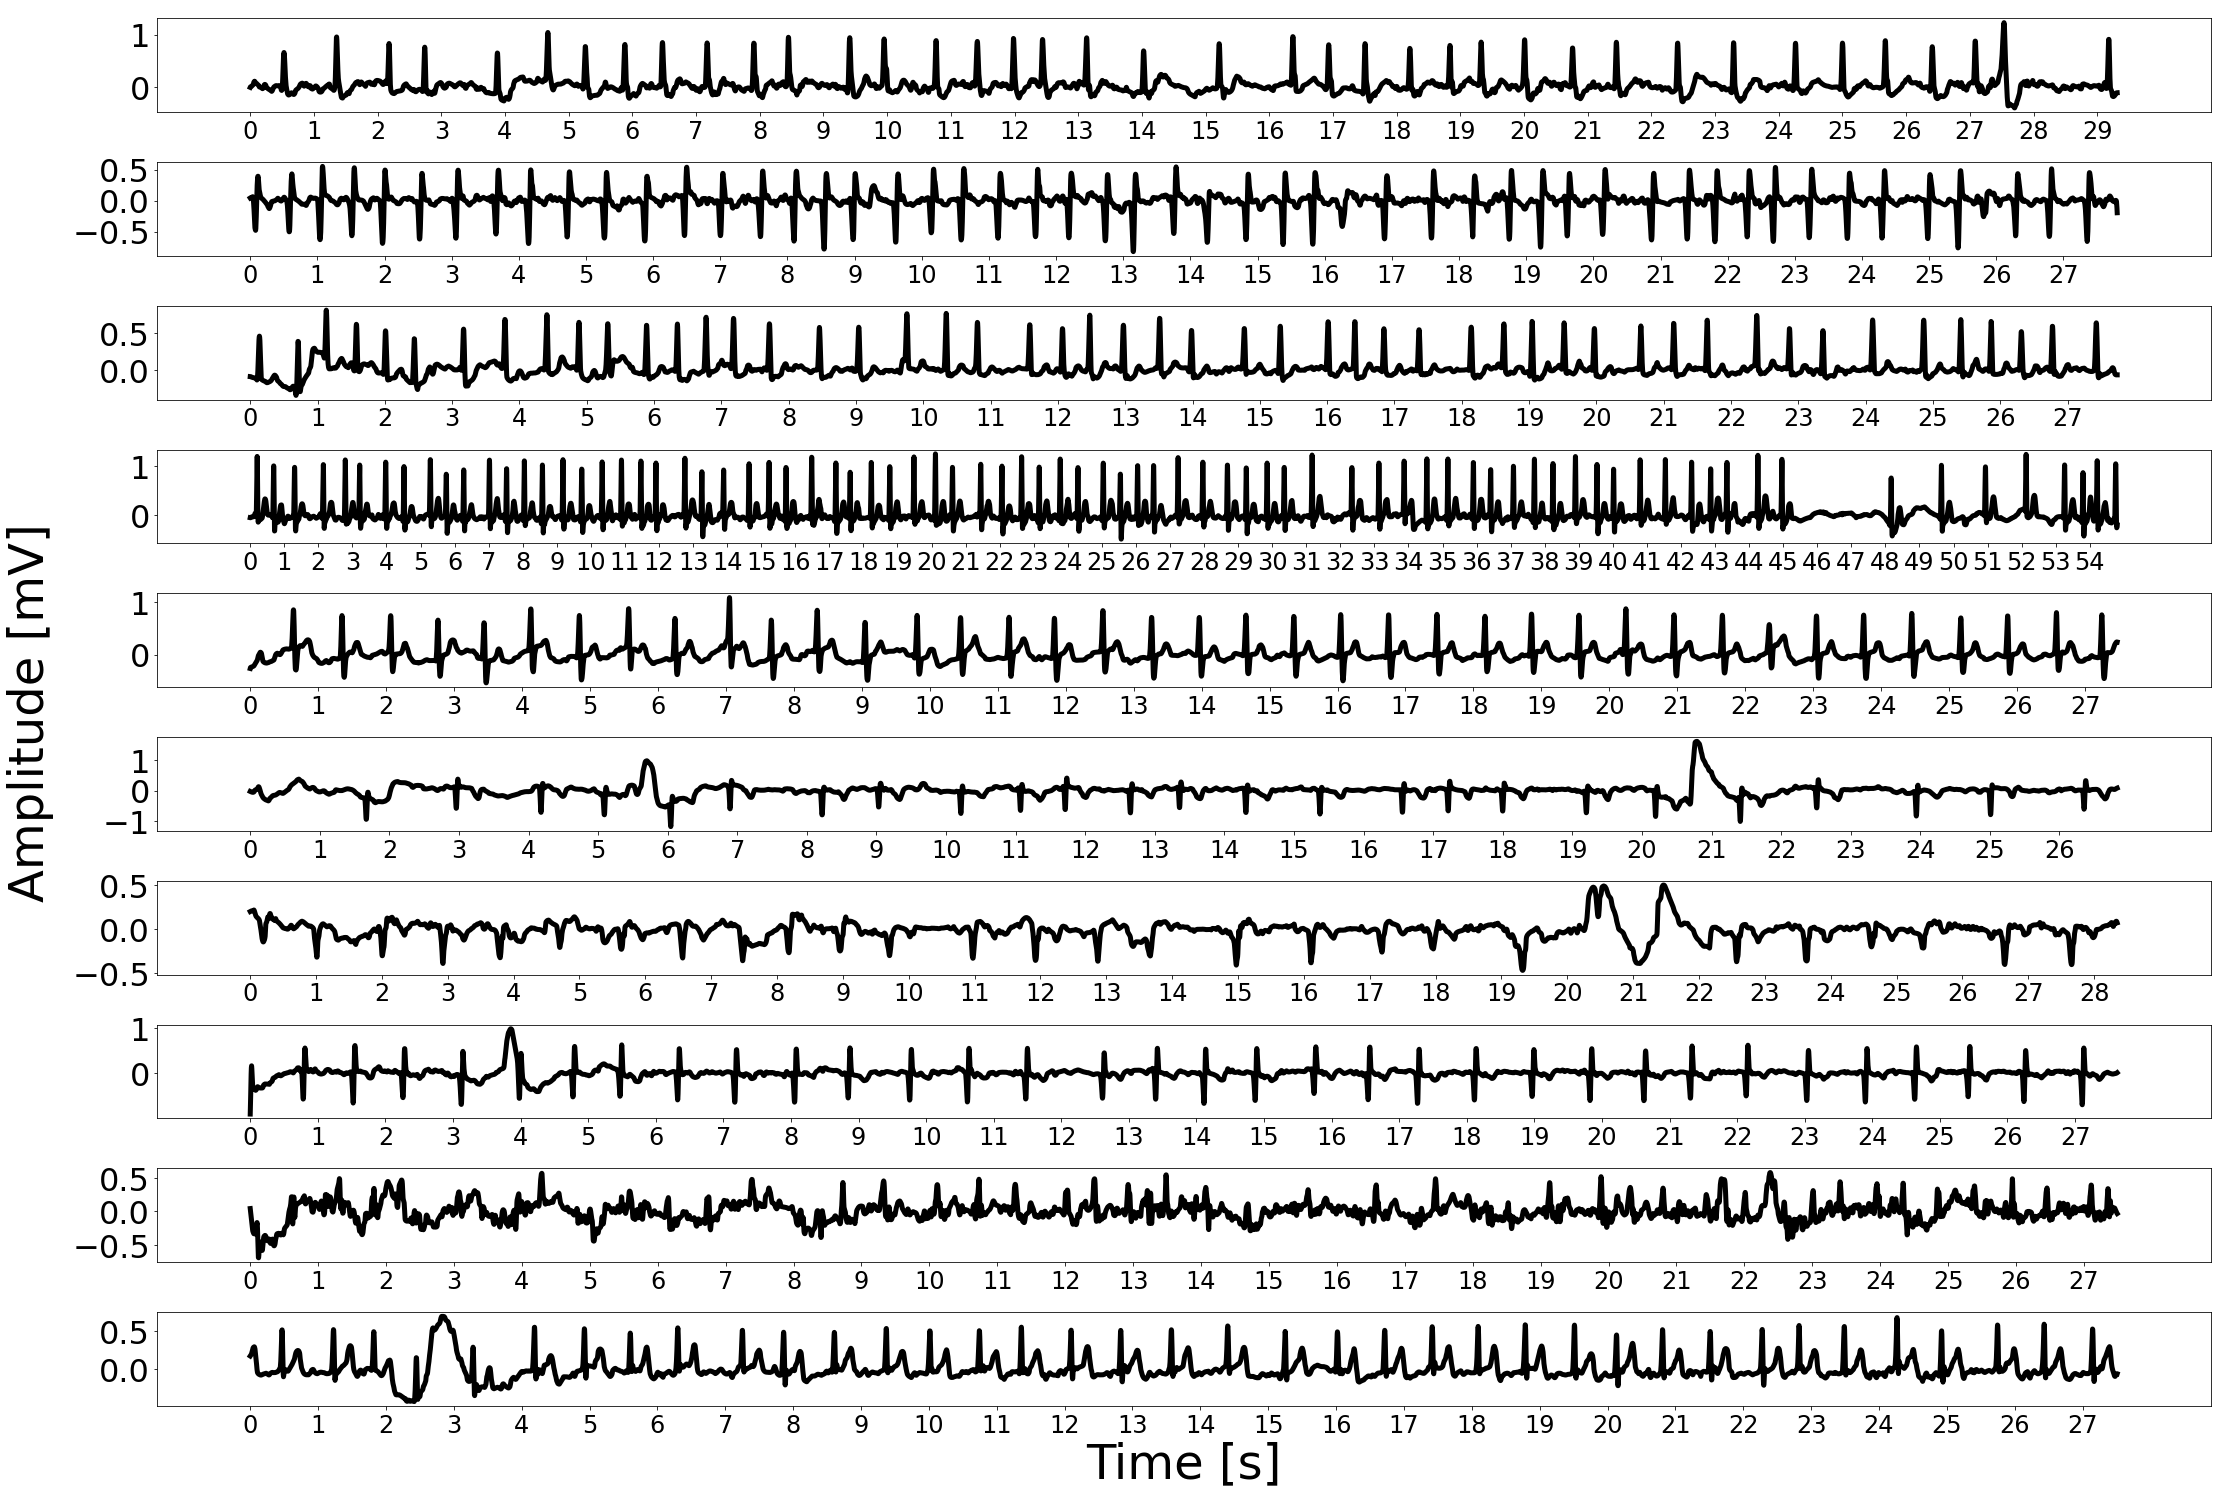

In [144]:
class_num = 1

sample_signal_ids = []
for sample_id in range(30,40):
    sample_signal_ids.append(int(np.argwhere(labels_train == class_num)[sample_id]))



T = 100      # sec
Offset = 0 # sec

# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(len(sample_signal_ids), 1)



for sample_id in range(len(sample_signal_ids)):
    ax = axs[sample_id]
    #ax.set_title("Class {}".format(sample_id))
    
    measurements0 = X_train_df.loc[sample_signal_ids[sample_id]].dropna().to_numpy(dtype='float32')
    if len(measurements0) < Fs*(Offset + T):
        start = Fs*Offset
        end = len(measurements0)
    else:
        start = Fs*Offset
        end = Fs*(Offset + T)
    
    seconds = np.arange(start, end) / Fs 
    x_labels = np.arange(start/Fs, end/Fs)
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements0[start: end] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

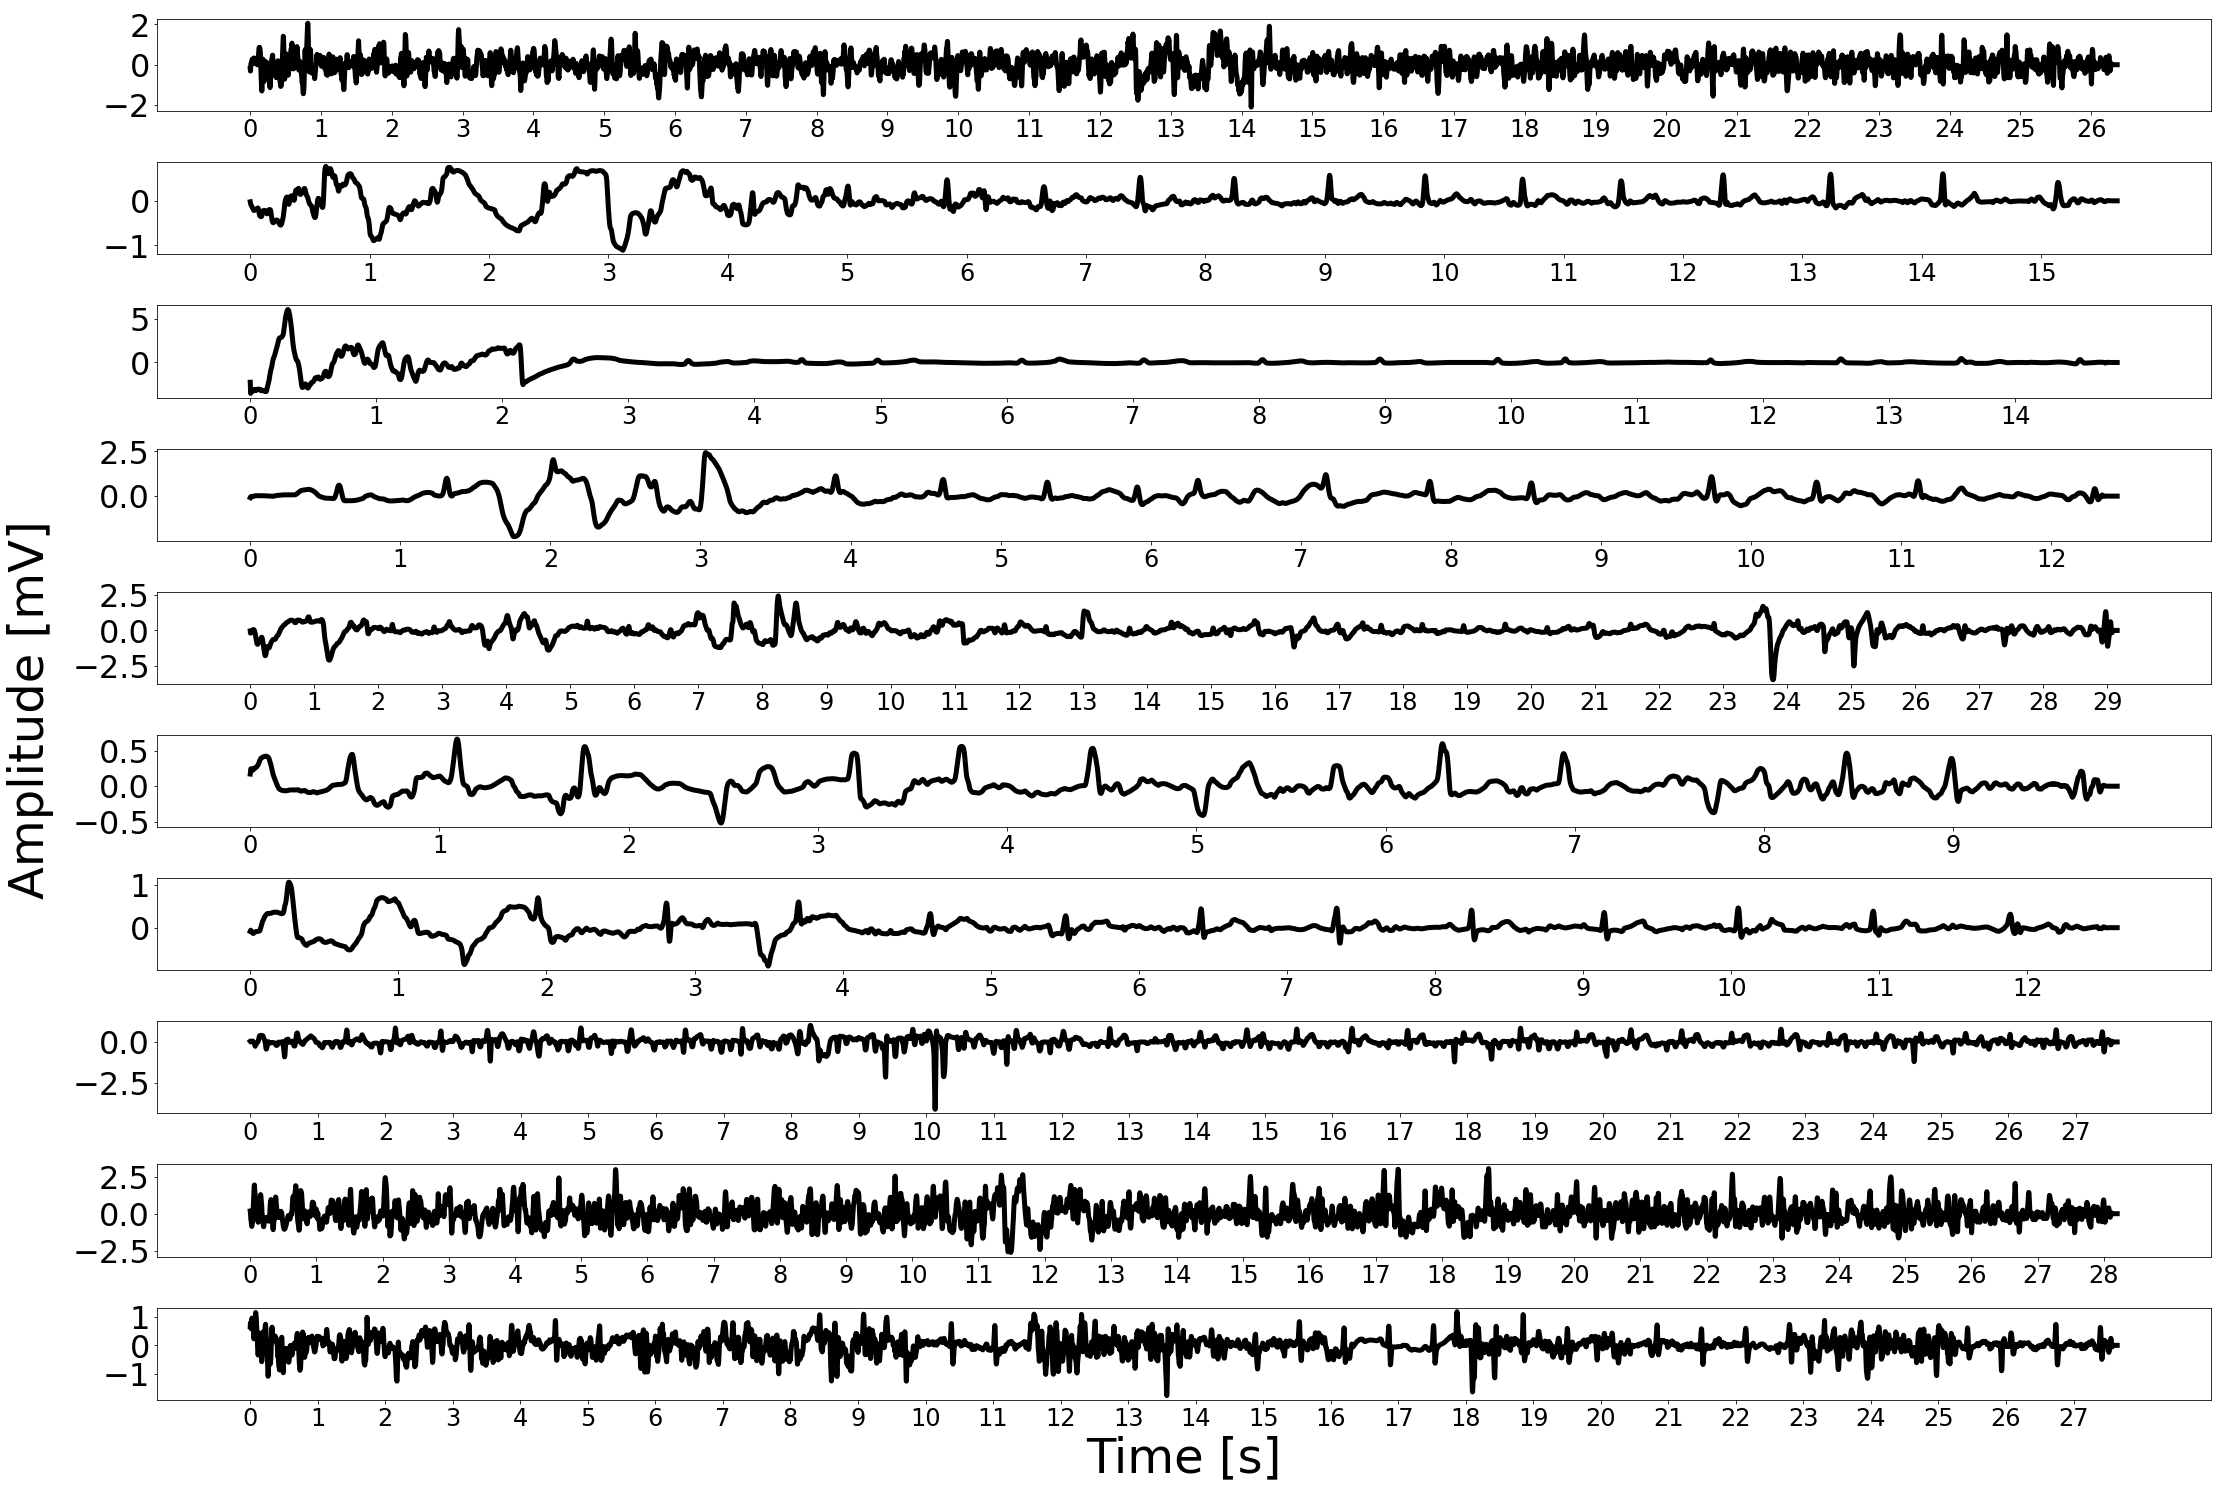

In [187]:
class_num = 3

sample_signal_ids = []
for sample_id in range(30,40):
    sample_signal_ids.append(int(np.argwhere(labels_train == class_num)[sample_id]))



T = 100      # sec
Offset = 0 # sec

# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(len(sample_signal_ids), 1)



for sample_id in range(len(sample_signal_ids)):
    ax = axs[sample_id]
    #ax.set_title("Class {}".format(sample_id))
    
    measurements0 = X_train_f_df.loc[sample_signal_ids[sample_id]].dropna().to_numpy(dtype='float32')
    if len(measurements0) < Fs*(Offset + T):
        start = Fs*Offset
        end = len(measurements0)
    else:
        start = Fs*Offset
        end = Fs*(Offset + T)
    
    seconds = np.arange(start, end) / Fs 
    x_labels = np.arange(start/Fs, end/Fs)
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements0[start: end] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

In [167]:
sample_signal_ids

[350, 357, 382, 383, 405, 412, 434, 440, 454, 467]

In [44]:
def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

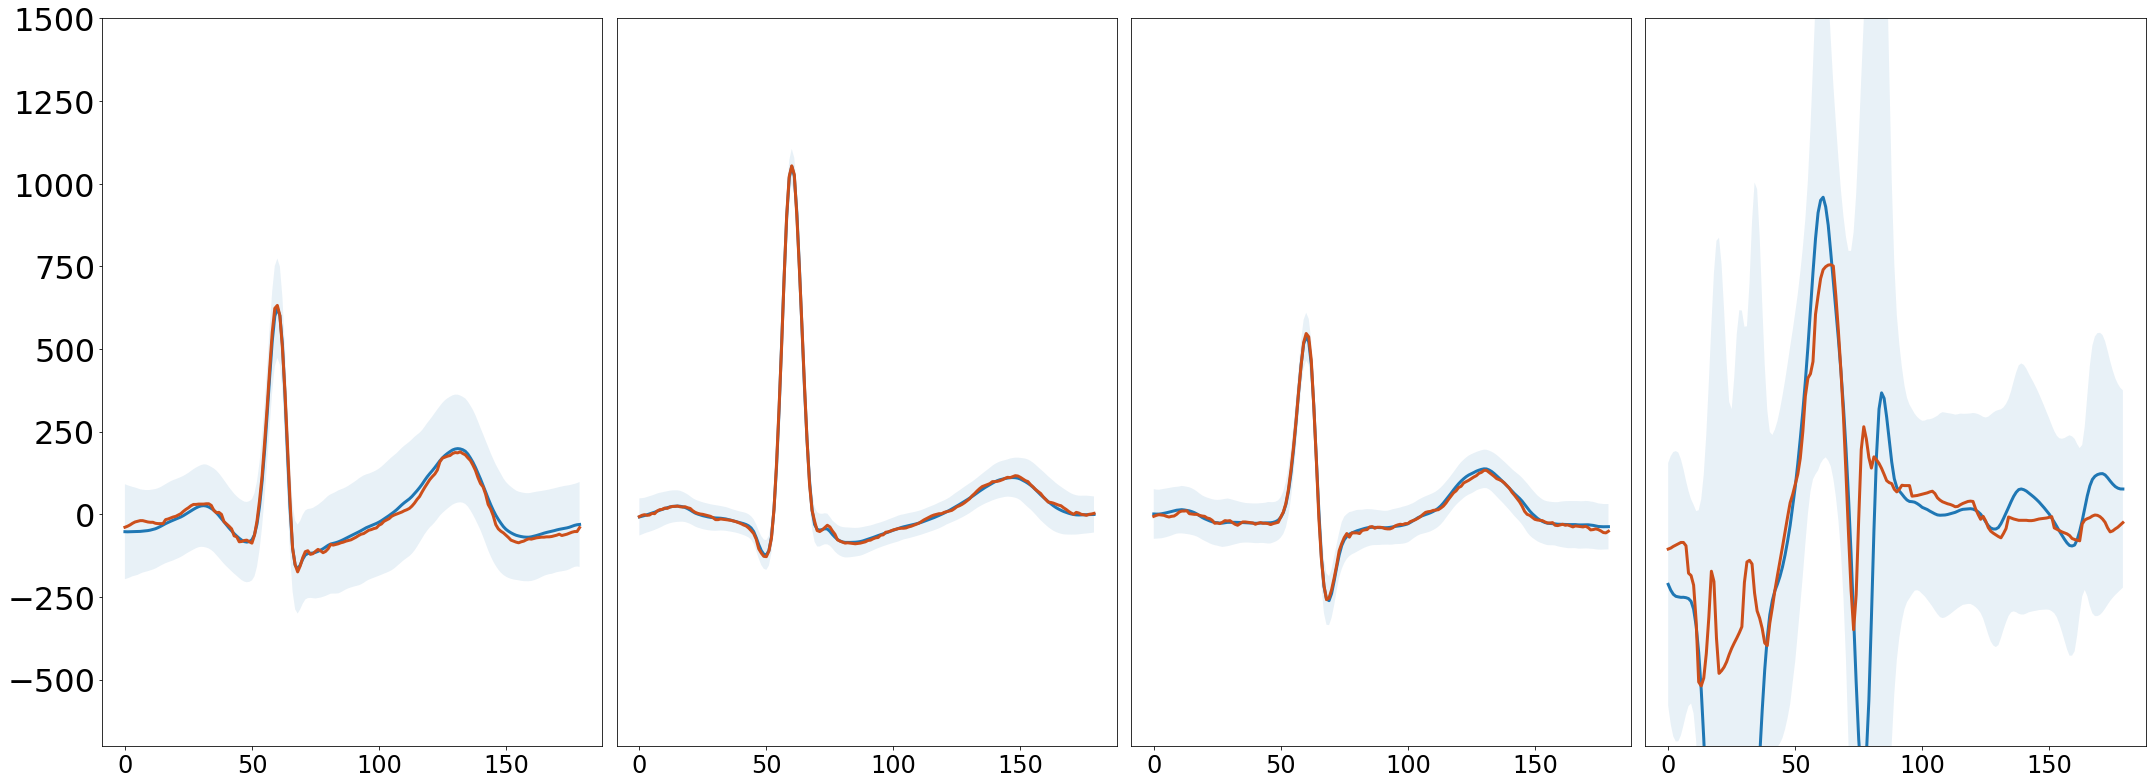

In [19]:
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_train == class_id)[10]))


plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    #ax.set_title("Class {}".format(class_id))
    ax.set_ylim([-700, 1500])
    if class_id:
        ax.set_yticks([])
    plot_features(X_train_f_df.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

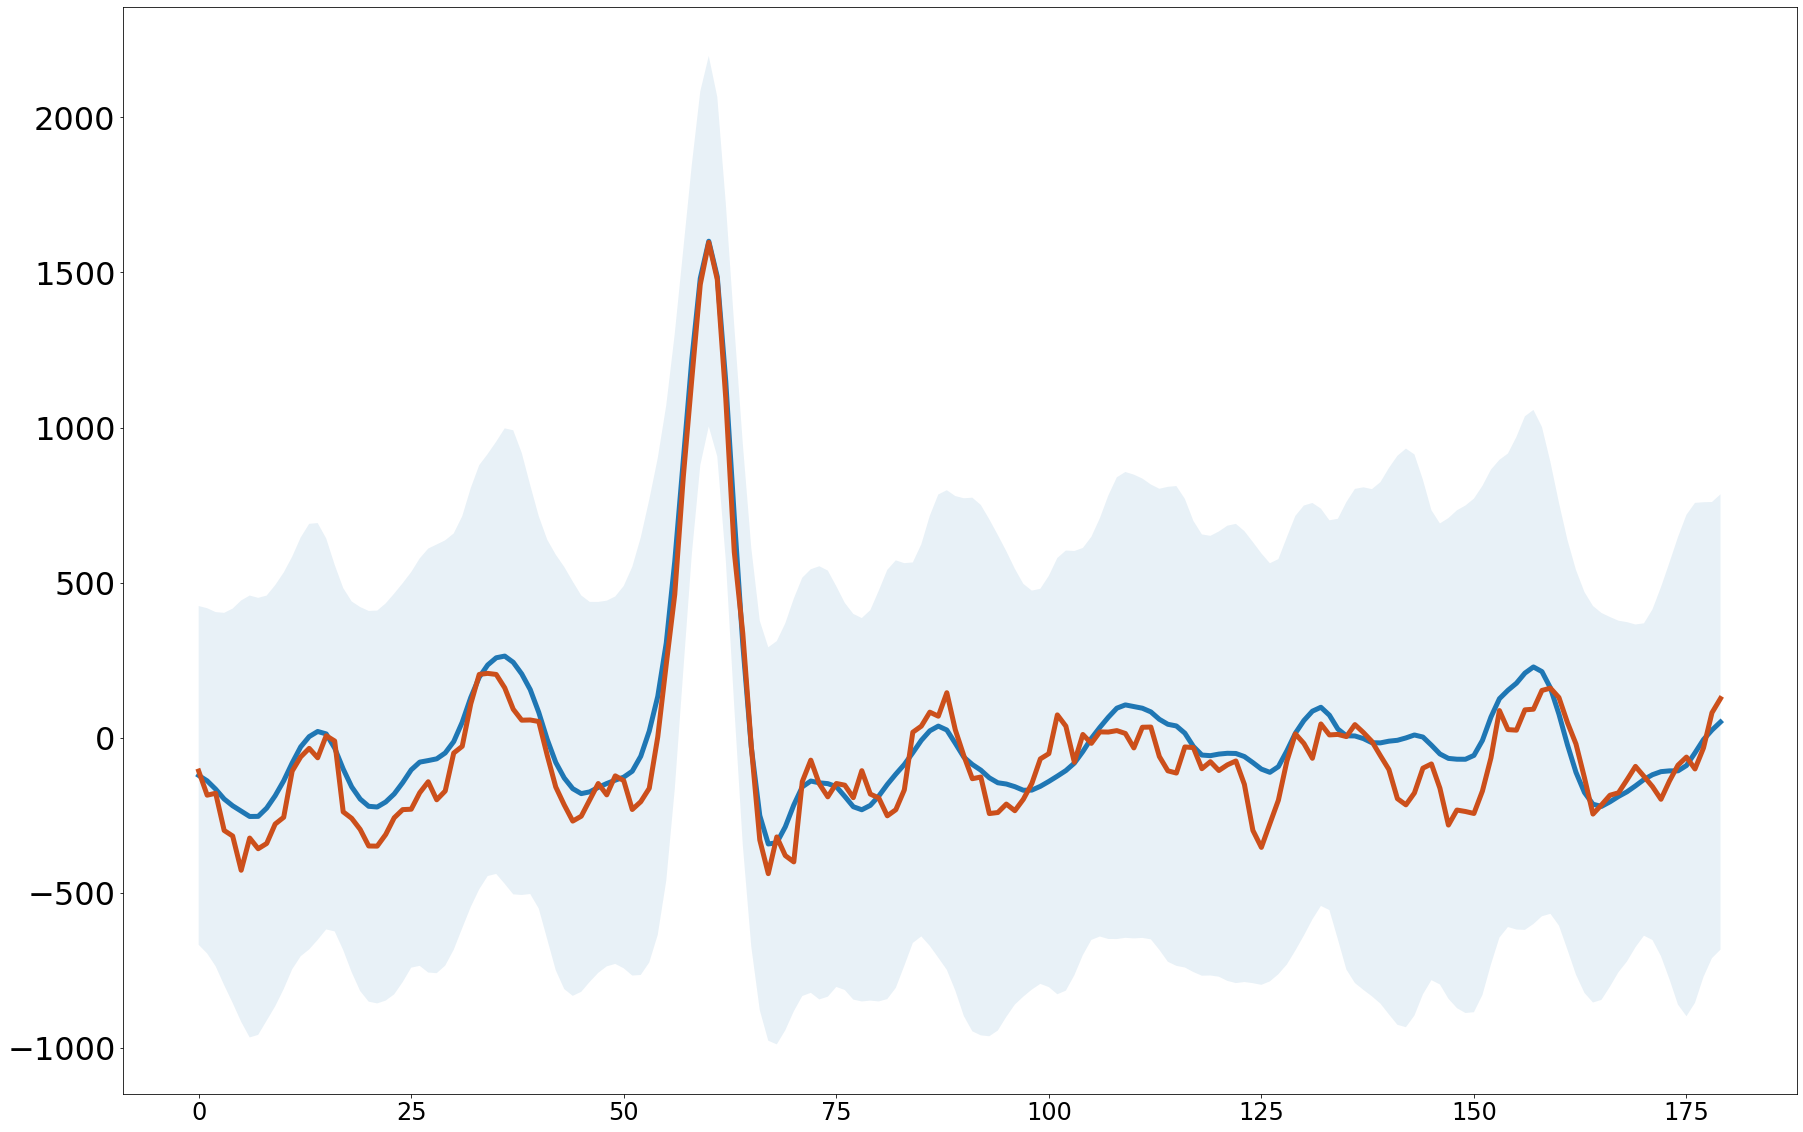

In [191]:
signal = X_train_f_df.loc[sample_signal_ids[8]].dropna().to_numpy(dtype='float32')
r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

#signal = X_train_df.loc[sample_signal_ids[0]].dropna().to_numpy(dtype='float32')
#plt.plot(beats[10,:])
#plt.plot(signal[:1000])
plot_features(signal)
plt.show

In [182]:
mean_vec = np.zeros(beats.shape[0])
var_vec = np.zeros(beats.shape[0])
for r in range(beats.shape[0]):
    mean_vec[r] = np.mean(beats[r])
    var_vec[r] = np.var(beats[r])

In [183]:
mean_vec

array([-105.11204529,   20.08506775,   33.1546669 ,  -97.02696228,
       -246.62052917,    1.55882156,   -6.05564213,  -52.59946442,
        -62.15700912,  -40.60231018,   21.30596733,  -19.71051788,
        -26.07400513,  -22.49132156,  -19.97782707,  -20.28860092,
        -11.89806271,   13.55884457,   -4.49068213,  -52.83794022,
         39.18797684,   -4.66014004,   -9.53663349,   -1.06900775])

In [186]:
var_vec/1000

array([37.93249609, 19.81145508, 24.34067969, 26.82571094, 47.68562109,
       32.70397852, 22.54356445, 19.47000781, 16.03368652, 21.68556055,
       23.19761719, 19.03100586, 19.97246484, 21.19466602, 18.48440234,
       19.62515625, 23.35116406, 20.29140625, 22.74394727, 67.825     ,
       51.73780469, 22.5416582 , 24.75083984, 13.78988379])

<function matplotlib.pyplot.show(close=None, block=None)>

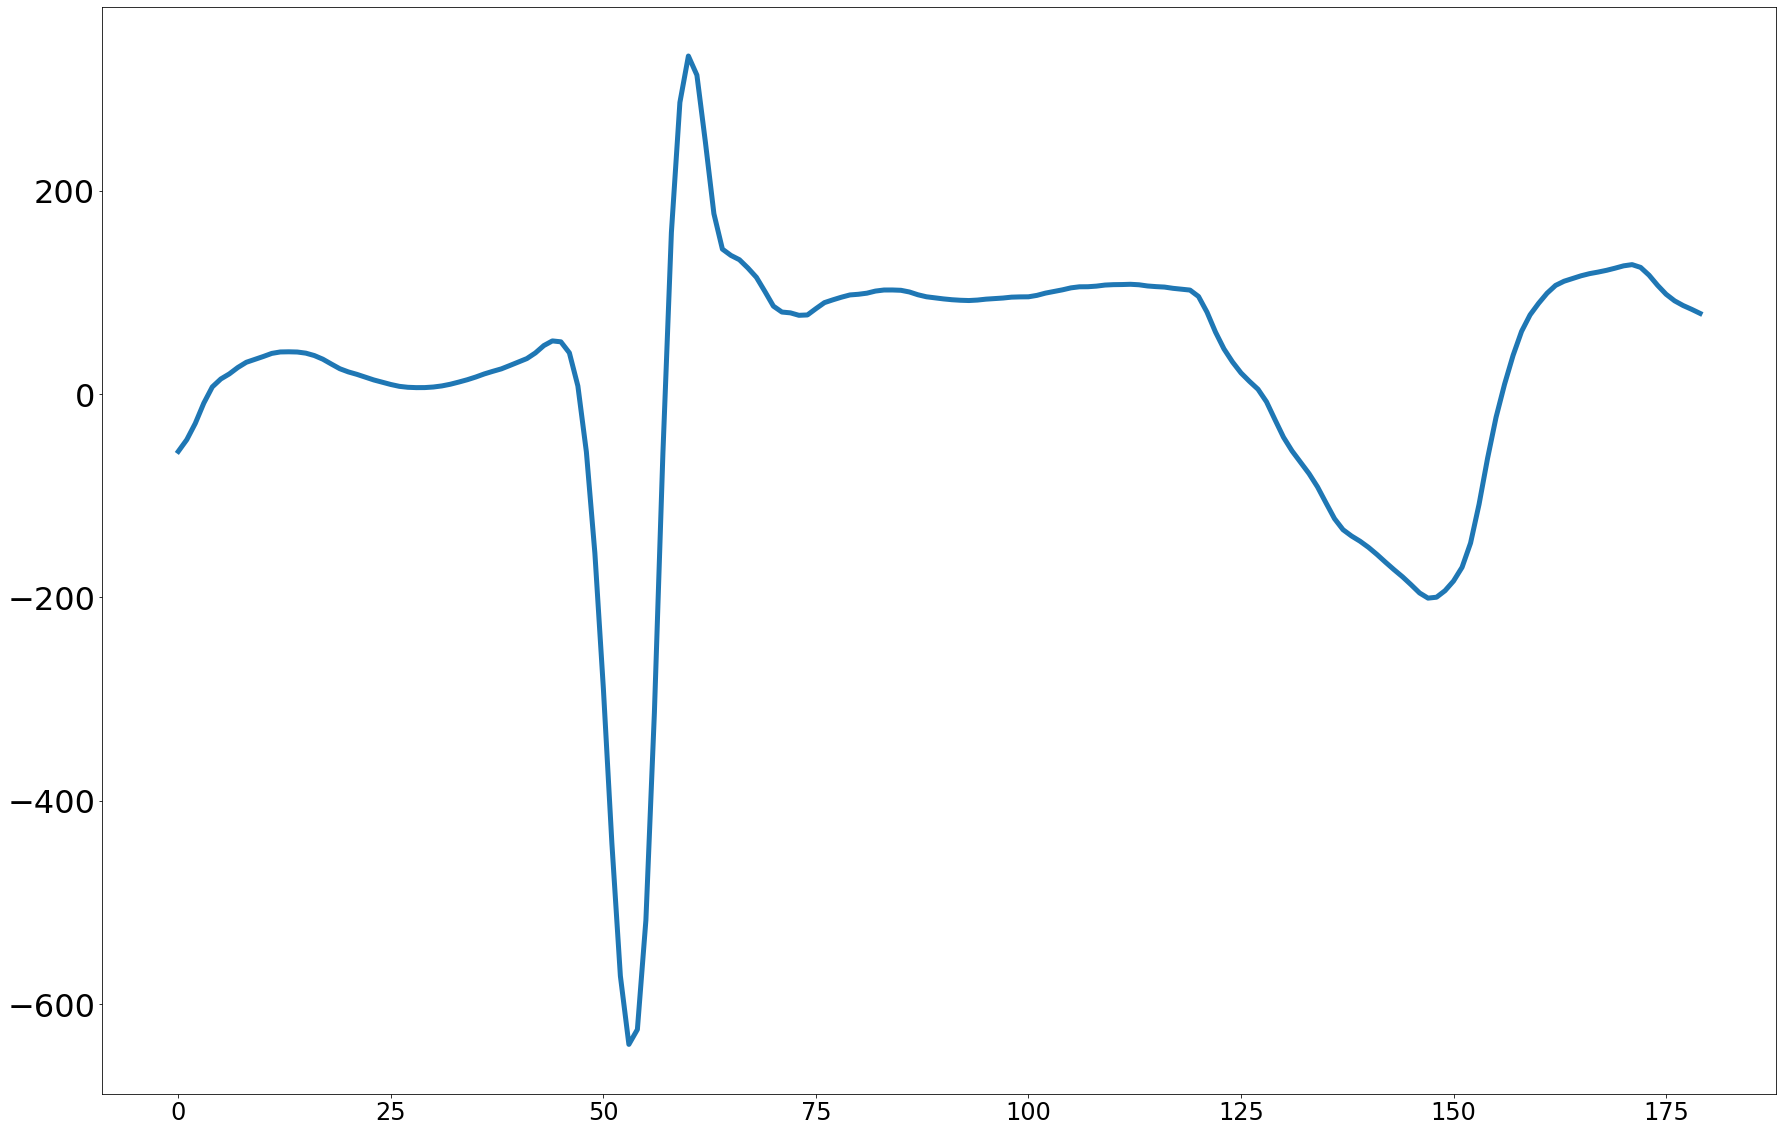

In [180]:
plt.plot(beats[1,:])
#plot_features(signal)
plt.show